In [1]:
import numpy as np
import xarray as xr
import metpy
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import zarr
import cmaps

ModuleNotFoundError: No module named 'zarr'

# 1. Identifying TC-induced precipitation (Kunkel et al. 2010, GRL)

- **Identication of TC-induced precipitation** Re: "A heavy precipitation event was considered to be associated with a TC if the track of 5° (latitude and/or longitude; approximately 500 km) radius of the location of the event on the same day."

- **Why this standard?** Re: The vast majority of TC are smaller than 500 km --> a 5°search radius should be large enough

- **Confirmation of TC-induced precipitation** Re: A rough correspondence between the TC-induced precipitation index and the number of landfalling TC.



## 1.1 Derivation of TC tracks

/Users/ilanvalencius/anaconda3/envs/xcdat/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/ilanvalencius/anaconda3/envs/xcdat/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


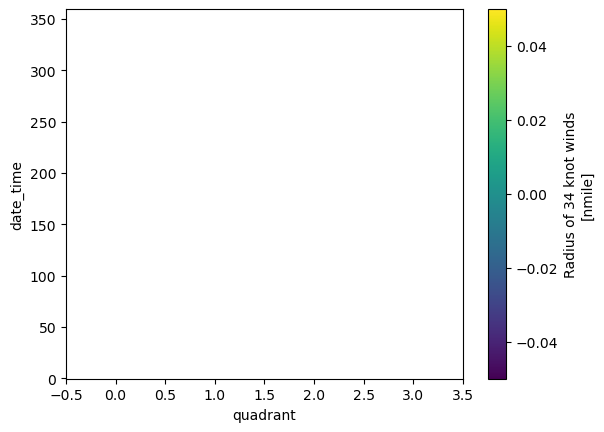

In [9]:
ds = xr.open_dataset('../../data/IBTrACS.since1980.v04r01.nc')

In [ ]:
'''
Read the TC tracks data
'''
# Shape of the data: (storm:4724, date_time: 360)
ds = xr.open_dataset('../../data/IDENTIFYING-TCs/IBTrACS.since1980.v04r01.nc')
TC_time = ds['time']
TC_lat = ds['lat']
TC_lon = ds['lon']


# Concatenate all data
TC_time_all = []
for i,each in enumerate(TC_time['storm']):
    TC_time_all.append(TC_time[i,:].dropna(dim='date_time').values)
TC_time_all = np.concatenate(TC_time_all).astype('datetime64[s]')       # Remove ns time
print('TC_time is over !!!')


# Concatenate all data
TC_lat_all = []
for i,each in enumerate(TC_lat['storm']):
    TC_lat_all.append(TC_lat[i,:].dropna(dim='date_time').values)
TC_lat_all = np.concatenate(TC_lat_all)
print('TC_lat is over !!!')


# Concatenate all data
TC_lon_all = []
for i,each in enumerate(TC_lon['storm']):
    TC_lon_all.append(TC_lon[i,:].dropna(dim='date_time').values)
TC_lon_all = np.concatenate(TC_lon_all)
TC_lon_all = np.where(TC_lon_all<0, TC_lon_all+360, TC_lon_all)        # Transform negative longitude --> > 180 longitude
print('TC_lon is over !!!') 


TC_time is over !!!
TC_lat is over !!!
TC_lon is over !!!


In [57]:
mask = (TC_time_all >= np.datetime64('1980-01-01T00:00:00')) & (TC_time_all < np.datetime64('1980-01-02T00:00:00'))
print(TC_time_all[mask])
print(TC_lat_all[mask])
print(TC_lon_all[mask])


['1980-01-01T00:00:00' '1980-01-01T03:00:00' '1980-01-01T06:00:00'
 '1980-01-01T09:00:00' '1980-01-01T12:00:00' '1980-01-01T15:00:00'
 '1980-01-01T18:00:00' '1980-01-01T21:00:00' '1980-01-01T12:00:00'
 '1980-01-01T15:00:00' '1980-01-01T18:00:00' '1980-01-01T21:00:00']
[-12.5 -12.2 -11.9 -11.7 -11.5 -11.3 -11.2 -11.2 -15.2 -15.  -14.8 -14.4]
[172.5 172.4 172.4 172.4 172.5 172.6 172.7 172.9  80.5  80.3  80.2  80.1]


In [48]:
## -------------------------------- Construct TC_activity array -------------------------------- ##
# Dimension-1: time
start_time = np.datetime64('1980-01-01T00:00:00')
end_time = np.datetime64('2024-07-31T23:59:59')
time_interval = np.timedelta64(3, 'h')
dim_time = np.arange(start_time, end_time, time_interval)

# Dimension-2: latitude
dim_lat = np.linspace(90,-90, 181, dtype=float)

# Dimension-2: latitude
dim_lon = np.linspace(0,360,361, dtype=float)

# Construct TC_activity array
TC_activity = xr.DataArray(np.zeros((len(dim_time), len(dim_lat), len(dim_lon)), dtype=int),
                           dims = ['time', 'longitude', 'latitude'],
                           coords = [dim_time, dim_lat, dim_lon])


# 2. Identifying fronts-induced precipitation (Catto et al. 2012, GRL)

- **Identification of fronts (Hewson 1998; Berry et al. 2011)** Re: Thermal front parameter (TFP), identifying front locations where the gradient of wet bulb potential temperature is a maximum in the direction of the moist isentropes. Also, classifying the front into cold, warm or quasi-stationary.

- **Identification of fronts-induced precipitation** Re: If the daily precipitation at a gridpoint is greater than zero, a surrounding box of 5° size is searched for the existence of a front. If a front occurs in the box at any of the four reanalysis time points within that day, then the precipitation is allocated to the front.

In [82]:
'''
Download the data for testing
'''
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'temperature', 'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '600', '900',
        ],
        'year': '2020',
        'month': '06',
        'day': [
            '01', '02', 
        ],
        'time': [
            '00:00', '06:00', '12:00',
            '18:00',
        ],
    },
    './test-front_data.nc')




2024-07-25 10:39:39,317 INFO Welcome to the CDS
2024-07-25 10:39:39,319 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2024-07-25 10:39:39,649 INFO Request is queued
2024-07-25 10:39:40,786 INFO Request is running
2024-07-25 10:39:48,499 INFO Request is completed
2024-07-25 10:39:48,502 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.mars.internal-1721921983.4928823-25554-19-e2a0d7ae-8a0b-44f8-90c1-195f5b408c17.nc to ./test-front_data.nc (95.1M)
2024-07-25 10:40:59,458 INFO Download rate 1.3M/s   


Result(content_length=99681552,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.mars.internal-1721921983.4928823-25554-19-e2a0d7ae-8a0b-44f8-90c1-195f5b408c17.nc)

In [195]:
'''
Calcultate the front variable F, following Parfitt et al. 2017, GRL.
'''
def cancel_unit(relative_vorticity_600hPa):
    relative_vorticity_600hPa_without_unit = xr.DataArray(relative_vorticity_600hPa.values, coords=relative_vorticity_600hPa.coords, dims=relative_vorticity_600hPa.dims)    # Cancel the unit in Xarray
    return relative_vorticity_600hPa_without_unit

# Read the data
ds = xr.open_dataset('./test-front_data.nc')
temp_600hPa = ds['t'].sel(level=600)
u_600hPa = ds['u'].sel(level=600)
v_600hPa = ds['v'].sel(level=600)

# Calculate the gradient of temperature
dtemp_dt_600hPa, dtemp_dy_600hPa, dtemp_dx_600hPa = mpcalc.gradient(temp_600hPa)    # unit:K*s^-1, K*m^-1, K*m^-1
dtemp_dt_600hPa = cancel_unit(dtemp_dt_600hPa)
dtemp_dy_600hPa = cancel_unit(dtemp_dy_600hPa)
dtemp_dx_600hPa = cancel_unit(dtemp_dx_600hPa)
absolute_HorizGrad_temp = np.hypot(dtemp_dx_600hPa, dtemp_dy_600hPa)                # Absolute of the horizontal gradient of temperature

# Calculate the relative vorticity
relative_vorticity_600hPa = mpcalc.vorticity(u_600hPa, v_600hPa)                    # unit: s^-1
relative_vorticity_600hPa = cancel_unit(relative_vorticity_600hPa)

# F* in Parfitt et al. 2017, GRL
F_star = relative_vorticity_600hPa * absolute_HorizGrad_temp.values

# F in Parfitt et al. 2017, GRL
absolute_HorizGrad_temp_scale = 0.45 / 100000                                       # 0.45 K / (100 km)   
f = 2 * metpy.constants.earth_avg_angular_vel.magnitude * np.sin(np.deg2rad(temp_600hPa['latitude']))
F = F_star / (f*absolute_HorizGrad_temp_scale)        


/opt/anaconda3/lib/python3.8/site-packages/pint/quantity.py:1313: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


# 3. Identifying thunderstorms-induced precipitation (no ref)

- **Identification of thunderstorms-induced precipitation** Re: CAPE

# 4. Identifying  monsoon-induced precipitation (Cavazos et al. 2008, GRL)

- **Identification of monsoon-induced precipitation** Precipitation in summertime are classified into TC-induced and monsoon-induced (non-TC).